#### Imports

In [21]:
import keras
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb

In [22]:
%matplotlib inline

#### SHAP Initialization

In [23]:
use_shap = True

In [24]:
# load JS visualization code to notebook
if use_shap:
    shap.initjs()

#### Train and Test Files

In [7]:
pwd

'C:\\Users\\t0272m1\\Projects\\HR Analytics'

In [5]:
path = 'E:/HR-Analytics/output/'

In [53]:
file_name = 'abs_shap_model_20190526_tbl.csv'
df = pd.read_csv('/'.join([path, file_name]))

In [54]:
df.shape

(20063, 48)

In [55]:
use_categoricals = False
if use_categoricals:
    df['crew'], _ = pd.factorize(df['crew'])
    df['production_line'], _ = pd.factorize(df['production_line'])
    df.drop(columns=['workdate'], inplace=True)
else:
    df.drop(columns=['workdate', 'crew', 'production_line'], inplace=True)

In [56]:
df.sample(20)

,group_total_cid,lost_hours,actual_hours,paa_hours,absences_unplanned,absences_late,absences_noshow,absences_any,mean_absence_pct,mean_experience,...,kp_residual_20,year,quarter,month,week,day,day_of_week,day_of_year,nth_kday,next_day_delta
7535,49.0,20.0,488.6,0.0,8,0.0,2.0,6.0,11.944444,88.875000,...,-4.000000,2018,3,9,35,1,5,244,1,3.0
15882,36.0,60.1,355.3,5.0,5,1.0,6.0,10.0,17.224490,74.204082,...,0.500000,2019,1,2,9,28,3,59,4,4.0
14942,128.0,42.6,1305.8,55.0,5,2.0,4.0,28.0,11.181818,210.066667,...,0.947368,2019,1,2,7,11,0,42,2,1.0
5051,20.0,0.0,203.4,16.0,0,0.0,0.0,5.0,9.560000,74.320000,...,0.000000,2018,2,6,25,21,3,172,3,4.0
12218,35.0,10.0,364.4,0.0,2,0.0,1.0,5.0,9.769231,34.794872,...,2.000000,2018,4,12,49,6,3,340,1,4.0
2237,95.0,39.5,867.1,10.0,2,0.0,3.0,14.0,10.053097,46.504425,...,0.400000,2018,1,3,13,28,2,87,4,1.0
5134,13.0,0.0,117.0,0.0,0,0.0,0.0,1.0,9.800000,67.266667,...,0.000000,2018,2,6,25,23,5,174,4,4.0
18015,53.0,30.0,525.7,0.0,4,0.0,3.0,7.0,14.027397,85.835616,...,2.666667,2019,2,4,15,9,1,99,2,3.0
12727,34.0,20.0,354.0,0.0,2,0.0,2.0,6.0,7.177419,122.483871,...,4.000000,2018,4,12,50,15,5,349,3,4.0
10090,46.0,22.0,471.1,0.0,8,1.0,2.0,4.0,12.754717,14.716981,...,0.666667,2018,4,10,43,22,0,295,4,1.0


In [57]:
for f in df.columns:
    print(f, df[f].dtype)

group_total_cid float64
lost_hours float64
actual_hours float64
paa_hours float64
absences_unplanned int64
absences_late float64
absences_noshow float64
absences_any float64
mean_absence_pct float64
mean_experience float64
absences_planned float64
home_canvasses float64
absences_fmla float64
peia_count float64
tpt_count float64
streak_1 float64
streak_2 float64
streak_3 float64
streak_4_plus float64
cluster float64
group_total float64
tpt_unplanned float64
tpt_extra float64
absences_unplanned_rolling_sum_5 float64
absences_unplanned_rolling_median_5 float64
absences_unplanned_rolling_sum_12 float64
absences_unplanned_rolling_median_12 float64
absences_unplanned_rolling_sum_20 float64
absences_unplanned_rolling_median_20 float64
actual_hours_rolling_mean_20 float64
actual_hours_rolling_median_20 float64
lost_hours_rolling_mean_20 float64
lost_hours_rolling_median_20 float64
kp_residual_5 float64
kp_residual_12 float64
kp_residual_20 float64
year int64
quarter int64
month int64
week int6

#### Model

In [58]:
target = 'absences_unplanned'
y = df[target]
X = df.drop(columns=[target])
print(X.shape, y.shape)

(20063, 44) (20063,)


In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13442, 44), (6621, 44), (13442,), (6621,))

#### XGBoost Training

In [61]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [62]:
params = {
    "objective": "count:poisson",
    "booster" : "gbtree",
    "eval_metric": "mae",
    "eta": 0.01,
    "tree_method": 'exact',
    "max_depth": 4,
    "subsample": 1,
    "colsample_bytree": 1,
    "silent": 1,
    "min_chil_weight": 1,
    "seed": 42
}

num_rounds = 1000
early_stopping_rounds = 10

In [63]:
# train XGBoost model
eval_set = [(dtrain, 'train'), (dtest, 'eval')]
gbm = xgb.train(params, dtrain, num_rounds, evals=eval_set, early_stopping_rounds=early_stopping_rounds)

[0]	train-mae:4.56163	eval-mae:4.5279
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:4.54063	eval-mae:4.50699
[2]	train-mae:4.51983	eval-mae:4.48635
[3]	train-mae:4.49912	eval-mae:4.46577
[4]	train-mae:4.47839	eval-mae:4.44515
[5]	train-mae:4.45783	eval-mae:4.42472
[6]	train-mae:4.43744	eval-mae:4.40448
[7]	train-mae:4.41737	eval-mae:4.38457
[8]	train-mae:4.39741	eval-mae:4.3648
[9]	train-mae:4.37757	eval-mae:4.34518
[10]	train-mae:4.35777	eval-mae:4.32558
[11]	train-mae:4.3381	eval-mae:4.30606
[12]	train-mae:4.31846	eval-mae:4.28651
[13]	train-mae:4.29896	eval-mae:4.26712
[14]	train-mae:4.27958	eval-mae:4.2478
[15]	train-mae:4.26027	eval-mae:4.22869
[16]	train-mae:4.24101	eval-mae:4.20956
[17]	train-mae:4.22182	eval-mae:4.19042
[18]	train-mae:4.20286	eval-mae:4.17157
[19]	train-mae:4.18391	eval-mae:4.15265
[20]	train-mae:4.1651	eval-mae:4.13395
[21]	train-mae:4.14648	eval-mae:4.

[201]	train-mae:2.20857	eval-mae:2.23581
[202]	train-mae:2.2035	eval-mae:2.23129
[203]	train-mae:2.19852	eval-mae:2.22677
[204]	train-mae:2.19359	eval-mae:2.22225
[205]	train-mae:2.18863	eval-mae:2.21774
[206]	train-mae:2.18373	eval-mae:2.21334
[207]	train-mae:2.17888	eval-mae:2.20893
[208]	train-mae:2.17406	eval-mae:2.20455
[209]	train-mae:2.16929	eval-mae:2.2002
[210]	train-mae:2.16454	eval-mae:2.19587
[211]	train-mae:2.15985	eval-mae:2.19164
[212]	train-mae:2.1552	eval-mae:2.18743
[213]	train-mae:2.15055	eval-mae:2.18322
[214]	train-mae:2.14601	eval-mae:2.17907
[215]	train-mae:2.14151	eval-mae:2.17493
[216]	train-mae:2.13702	eval-mae:2.17078
[217]	train-mae:2.1326	eval-mae:2.16673
[218]	train-mae:2.12821	eval-mae:2.16271
[219]	train-mae:2.12383	eval-mae:2.15871
[220]	train-mae:2.11949	eval-mae:2.1548
[221]	train-mae:2.11522	eval-mae:2.15096
[222]	train-mae:2.11092	eval-mae:2.14709
[223]	train-mae:2.1067	eval-mae:2.14328
[224]	train-mae:2.10252	eval-mae:2.13954
[225]	train-mae:2.0983

[402]	train-mae:1.72494	eval-mae:1.82472
[403]	train-mae:1.7241	eval-mae:1.82414
[404]	train-mae:1.72322	eval-mae:1.82348
[405]	train-mae:1.72237	eval-mae:1.82285
[406]	train-mae:1.72156	eval-mae:1.82229
[407]	train-mae:1.7207	eval-mae:1.8217
[408]	train-mae:1.71979	eval-mae:1.82103
[409]	train-mae:1.71896	eval-mae:1.82046
[410]	train-mae:1.71811	eval-mae:1.81983
[411]	train-mae:1.71734	eval-mae:1.8193
[412]	train-mae:1.71656	eval-mae:1.81871
[413]	train-mae:1.7157	eval-mae:1.81807
[414]	train-mae:1.71491	eval-mae:1.81745
[415]	train-mae:1.71417	eval-mae:1.81694
[416]	train-mae:1.71345	eval-mae:1.81643
[417]	train-mae:1.7127	eval-mae:1.81592
[418]	train-mae:1.71195	eval-mae:1.81538
[419]	train-mae:1.71123	eval-mae:1.81483
[420]	train-mae:1.7105	eval-mae:1.8143
[421]	train-mae:1.70981	eval-mae:1.81382
[422]	train-mae:1.70912	eval-mae:1.81333
[423]	train-mae:1.70839	eval-mae:1.81276
[424]	train-mae:1.70775	eval-mae:1.81227
[425]	train-mae:1.7071	eval-mae:1.81178
[426]	train-mae:1.70647	e

[603]	train-mae:1.6417	eval-mae:1.76849
[604]	train-mae:1.64148	eval-mae:1.76834
[605]	train-mae:1.6412	eval-mae:1.76815
[606]	train-mae:1.64105	eval-mae:1.76804
[607]	train-mae:1.64078	eval-mae:1.76786
[608]	train-mae:1.64066	eval-mae:1.76778
[609]	train-mae:1.64046	eval-mae:1.76766
[610]	train-mae:1.64026	eval-mae:1.76751
[611]	train-mae:1.64008	eval-mae:1.76742
[612]	train-mae:1.63986	eval-mae:1.76723
[613]	train-mae:1.63967	eval-mae:1.76709
[614]	train-mae:1.63946	eval-mae:1.76698
[615]	train-mae:1.63936	eval-mae:1.76689
[616]	train-mae:1.6392	eval-mae:1.76679
[617]	train-mae:1.63902	eval-mae:1.76669
[618]	train-mae:1.63884	eval-mae:1.76655
[619]	train-mae:1.63856	eval-mae:1.7664
[620]	train-mae:1.63847	eval-mae:1.76631
[621]	train-mae:1.63829	eval-mae:1.76619
[622]	train-mae:1.6381	eval-mae:1.76606
[623]	train-mae:1.63792	eval-mae:1.76599
[624]	train-mae:1.63777	eval-mae:1.7659
[625]	train-mae:1.63769	eval-mae:1.76581
[626]	train-mae:1.63752	eval-mae:1.76573
[627]	train-mae:1.6373

[804]	train-mae:1.61608	eval-mae:1.75449
[805]	train-mae:1.616	eval-mae:1.75446
[806]	train-mae:1.61588	eval-mae:1.75439
[807]	train-mae:1.61582	eval-mae:1.75447
[808]	train-mae:1.61579	eval-mae:1.75443
[809]	train-mae:1.6157	eval-mae:1.75438
[810]	train-mae:1.61561	eval-mae:1.75432
[811]	train-mae:1.61543	eval-mae:1.75426
[812]	train-mae:1.61535	eval-mae:1.75424
[813]	train-mae:1.61529	eval-mae:1.75432
[814]	train-mae:1.61519	eval-mae:1.75425
[815]	train-mae:1.61509	eval-mae:1.75415
[816]	train-mae:1.61499	eval-mae:1.75412
[817]	train-mae:1.61494	eval-mae:1.75408
[818]	train-mae:1.61489	eval-mae:1.75407
[819]	train-mae:1.61483	eval-mae:1.75402
[820]	train-mae:1.61473	eval-mae:1.75399
[821]	train-mae:1.61466	eval-mae:1.75396
[822]	train-mae:1.61458	eval-mae:1.75391
[823]	train-mae:1.61448	eval-mae:1.75388
[824]	train-mae:1.61441	eval-mae:1.75385
[825]	train-mae:1.61437	eval-mae:1.75384
[826]	train-mae:1.61428	eval-mae:1.75378
[827]	train-mae:1.61413	eval-mae:1.75384
[828]	train-mae:1.6

In [64]:
gbm

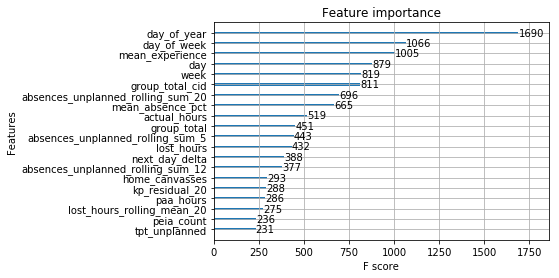

In [65]:
xgb.plot_importance(gbm, max_num_features=20)

#### XGBoost Testing

In [66]:
ypred = gbm.predict(xgb.DMatrix(X_test))

In [71]:
ypred.shape

(6621,)

In [67]:
ypred.max()

85.930016

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)

In [54]:
# visualize a prediction's explanation
shap_index = 5000
shap.force_plot(explainer.expected_value, shap_values[shap_index,:], df_train.iloc[shap_index,:])

In [57]:
slice_start = 5000
slice_end = 5100
shap.force_plot(explainer.expected_value, shap_values[slice_start:slice_end], df_train[slice_start:slice_end])

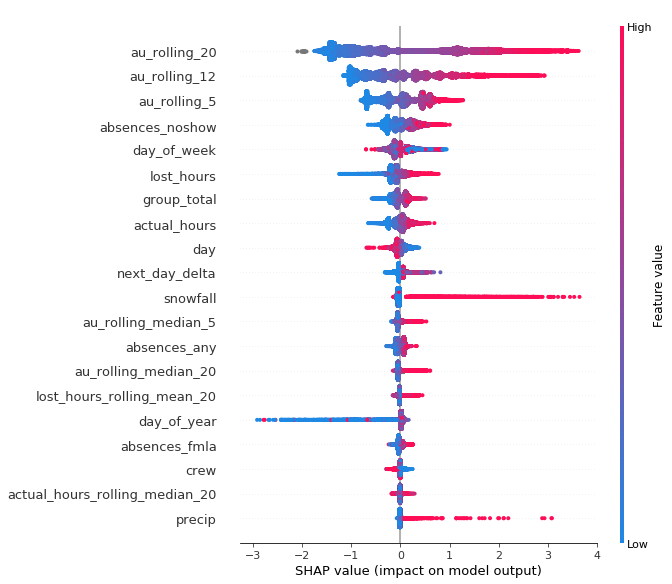

In [62]:
# summarize the effects of all the features
# note inverse day of week
shap.summary_plot(shap_values, df_train)